In [18]:
# importing necessary liberaries
import os
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt



In [19]:
# folder paths
order_data_folder = r'E:\Documents\6th Semester\AI\training_data\training_data\order_data'
POI_data_folder = r'E:\Documents\6th Semester\AI\training_data\training_data\poi_data'
region_data_folder = r'E:\Documents\6th Semester\AI\training_data\training_data\cluster_map\cluster_map'
weather_data_folder = r'E:\Documents\6th Semester\AI\training_data\training_data\weather_data'


# empty list to store dataframes from each file
dataframes = []
df1 = []     # order_data
df2 = []     # region_info
df3 = []     # weather_data
df4 = []     # POI data

# read and normalize data from order data files
count=0
order_date_prefix = 'order_data_2016-01-**'
for filename in glob.glob(os.path.join(order_data_folder,order_date_prefix)):
    if count==2:
        break
    else:
        with open(filename, 'r') as f:
            content = f.readlines()
            content = [x.strip() for x in content]
            df = pd.DataFrame([x.split('\t') for x in content], columns=['order_id', 'driver_id', 'passenger_id', 'start_region_hash', 'dest_region_hash', 'price', 'time'])
            df1.append(df)
            df1_concatenated = pd.concat(df1, ignore_index=True)
    count+=1   

# read and normalize data from region data file
region_filename = os.path.join(region_data_folder)
with open(region_filename, 'r') as f:
    content = f.readlines()
    content = [x.strip() for x in content]
    df2 = pd.DataFrame([x.split('\t') for x in content], columns=['region_hash', 'region_id'])

# read and normalize data from weather files
count=0
weather_date_prefix = 'weather_data_2016-01-**'
for filename in glob.glob(os.path.join(weather_data_folder,weather_date_prefix)):
    if count==2:
        break
    else:
        with open(filename, 'r') as f:
            content = f.readlines()
            content = [x.strip() for x in content]
            df = pd.DataFrame([x.split('\t') for x in content], columns=['time', 'weather', 'temperature', 'PM2.5'])
            df3.append(df)
            df3_concatenated = pd.concat(df3, ignore_index=True)
    count+=1       


In [20]:
# ----------------------------------------------------  Normalizing DataFrames -----------------------------------------------------
# table 1 containing Order info join Region hash where start_region_hash == region_hash
table = df1_concatenated.join(df2.set_index('region_hash'), on='start_region_hash')
tb = pd.DataFrame(table)

# join table1 and df3 on the basis of 'time'
#table = pd.merge(tb, df3_concatenated, on='time', how='inner')
table1 = table.sort_values(by='time')

table1['time'] = table1['time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
table1 = table1.sort_values(by=['region_id'], ascending=True)
table1 = table1.groupby('region_id').apply(lambda x: x.sort_values('time'))

## writing weather data to csv file
df3_concatenated['time'] = df3_concatenated['time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df3_concatenated.set_index('time', inplace=True)
df3_concatenated.to_csv('weather.csv', index=True)

# reset index after sorting
#table1 = df.reset_index(drop=True)
#table1.set_index('time', inplace=True)
table1 = table1.drop(columns=['region_id'])
table1.to_csv('data.csv', index=True)

In [21]:
# count the number of passenger ids and driver ids (non-null) from the table 'table1' for timestamp of 10 minutes
counts = []
#start_time = table1['time'].min()
#end_time = table1['time'].max()

for region_id, group in table1.groupby('region_id'):
    start_time = table1['time'].min()
    end_time = table1['time'].max()
    while start_time <= end_time:
        end_time_for_count = start_time + pd.Timedelta(minutes=10)
        subset = group.loc[(group['time'] >= start_time) & (group['time'] < end_time_for_count)]

        passenger_count = subset['passenger_id'].count()
        driver = subset['driver_id'].values
        driver_count = 0
        for i in range(passenger_count):
            if driver[i] != 'NULL':
                driver_count += 1
        gap = passenger_count - driver_count
        counts.append({'timestamp': start_time, 'passenger_count': passenger_count, 'driver_count': driver_count, 'Gap': gap, 'region_id': region_id})
        start_time += pd.Timedelta(minutes=10)

# create a new dataframe with the counts and save it to a new csv file
counts_df = pd.DataFrame(counts)
counts_df.set_index('timestamp', inplace=True)
counts_df.to_csv('counts.csv')

In [22]:
# read counts and weather data from csv files
counts_df = pd.read_csv('counts.csv')
weather_df = pd.read_csv('weather.csv')

# convert the 'time' column to a datetime object
counts_df['timestamp'] = pd.to_datetime(counts_df['timestamp'])
weather_df['time'] = pd.to_datetime(weather_df['time'])


# extract the hour and minute parts and add them to new columns
weather_df['hour'] = weather_df['time'].dt.strftime('%H')
weather_df['minute'] = weather_df['time'].dt.strftime('%M')
counts_df['hour'] = counts_df['timestamp'].dt.strftime('%H')
counts_df['minute'] = counts_df['timestamp'].dt.strftime('%M')

# extract only the date component
counts_df['date'] = counts_df['timestamp'].dt.date
weather_df['date'] = weather_df['time'].dt.date

joined_df = pd.merge(counts_df, weather_df, on=['hour', 'minute', 'date'], how='inner')

# drop the hour and minute columns
joined_df.drop(columns=['hour', 'minute','date','time'], inplace=True)

# save the joined dataframe to a new csv file
joined_df.to_csv('joined_data.csv', index=False)



# model 1: linear regression

Mean squared error: 3897.086678609921
R-squared score: 7.449207358378729e-05
Mean absolute error:16.075
Accuracy: 0.00012284059832234906


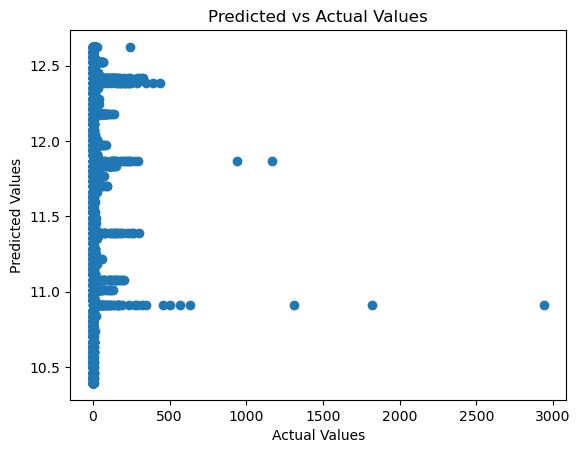

Predicted gap: 12.315186823045517


In [34]:
joined_df = pd.read_csv('joined_data.csv')
X = joined_df[['region_id']]
y = joined_df['Gap']

# splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model1 = LinearRegression()
model1.fit(X_train, y_train)

# testing 
y_pred = model1.predict(X_test)

# performance evaluation on the basis of mean square, R2 and mean_absolute_error
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('Mean squared error:', mse)
print('R-squared score:', r2)
print('Mean absolute error:{:.3f}'.format(mae))

# Calculate the accuracy of the model
accuracy = model1.score(X, y)
print('Accuracy:', accuracy)

# plotting 
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

# create a new DataFrame with input data
new_data = pd.DataFrame({'region_id': [10]})

# testing
# use the trained model to predict the output value for the new data
new_gap = model1.predict(new_data)

# print the predicted output value
print('Predicted gap:', new_gap[0])

# Model 2: Multi-Regression Model

Mean squared error: 3991.696608992349
R-squared score: 0.011753092861382819
Mean absolute error:16.469
Accuracy: 0.010333328085519566


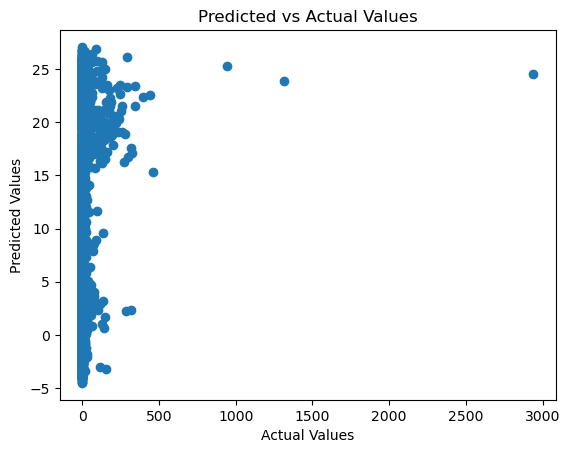

Predicted gap: 19.709033131744192


In [35]:
# load data into pandas dataframe
data = pd.read_csv('joined_data.csv', parse_dates=['timestamp'])

# extract year, month, day, hour, minute, second from timestamp
data['year'] = data['timestamp'].dt.year
data['month'] = data['timestamp'].dt.month
data['day'] = data['timestamp'].dt.day
data['hour'] = data['timestamp'].dt.hour
data['minute'] = data['timestamp'].dt.minute
data['second'] = data['timestamp'].dt.second

# select features and target variable
X = data[['year', 'month', 'day', 'hour', 'minute', 'second', 'region_id']]
y = data['Gap']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# make predictions on test set
y_pred = model.predict(X_test)

# performance evaluation on the basis of mean square, R2 and mean_absolute_error
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('Mean squared error:', mse)
print('R-squared score:', r2)
print('Mean absolute error:{:.3f}'.format(mae))

# Calculate the accuracy of the model
accuracy = model.score(X, y)
print('Accuracy:', accuracy)

# plot predicted vs actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

# testing 
# define input parameters for prediction
year = 2016
month = 1
day = 1
hour = 12
minute = 0
second = 0
region_id = 1

# create a dataframe for the input parameters
new_data = pd.DataFrame({
    'year': [year],
    'month': [month],
    'day': [day],
    'hour': [hour],
    'minute': [minute],
    'second': [second],
    'region_id': [region_id]
})

# make prediction on the new data
gap = model.predict(new_data)[0]

# print the predicted gap
print('Predicted gap:', gap)

# Model 3:  Regression Tree

In [41]:
import numpy as np

# convert datetime column to Unix timestamps in minutes
unix_timestamps = (joined_df['timestamp'] - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 'm')

# replace the datetime column with the Unix timestamps
joined_df['timestamp'] = unix_timestamps

C:\Users\shahw\AppData\Local\Temp\ipykernel_15144\3976263631.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  unix_timestamps = (joined_df['timestamp'] - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 'm')


TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Timestamp'

In [24]:
from sklearn.model_selection import train_test_split

X = joined_df.drop('Gap', axis=1)
y = joined_df['Gap']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
from sklearn.tree import DecisionTreeRegressor

reg_tree = DecisionTreeRegressor(max_depth=5)
reg_tree.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=5)

In [26]:
y_pred = reg_tree.predict(X_test)


In [39]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}, R^2: {r2}')
#  performance evaluation on the basis of mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print('Mean absolute error:{:.3f}'.format(mae))



MSE: 3991.696608992349, R^2: 0.011753092861382819
Mean absolute error:16.469


In [29]:
#  performance evaluation on the basis of mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print('Mean absolute error:{:.3f}'.format(mae))

Mean absolute error:5.218


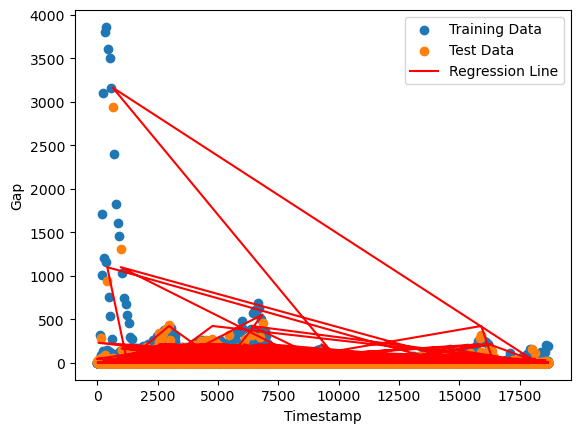

In [30]:
import matplotlib.pyplot as plt

# plot the training data
plt.scatter(X_train.index, y_train, label='Training Data')

# plot the test data
plt.scatter(X_test.index, y_test, label='Test Data')

# plot the regression line
plt.plot(X_test.index, y_pred, color='red', label='Regression Line')

plt.xlabel('Timestamp')
plt.ylabel('Gap')
plt.legend()
plt.show()


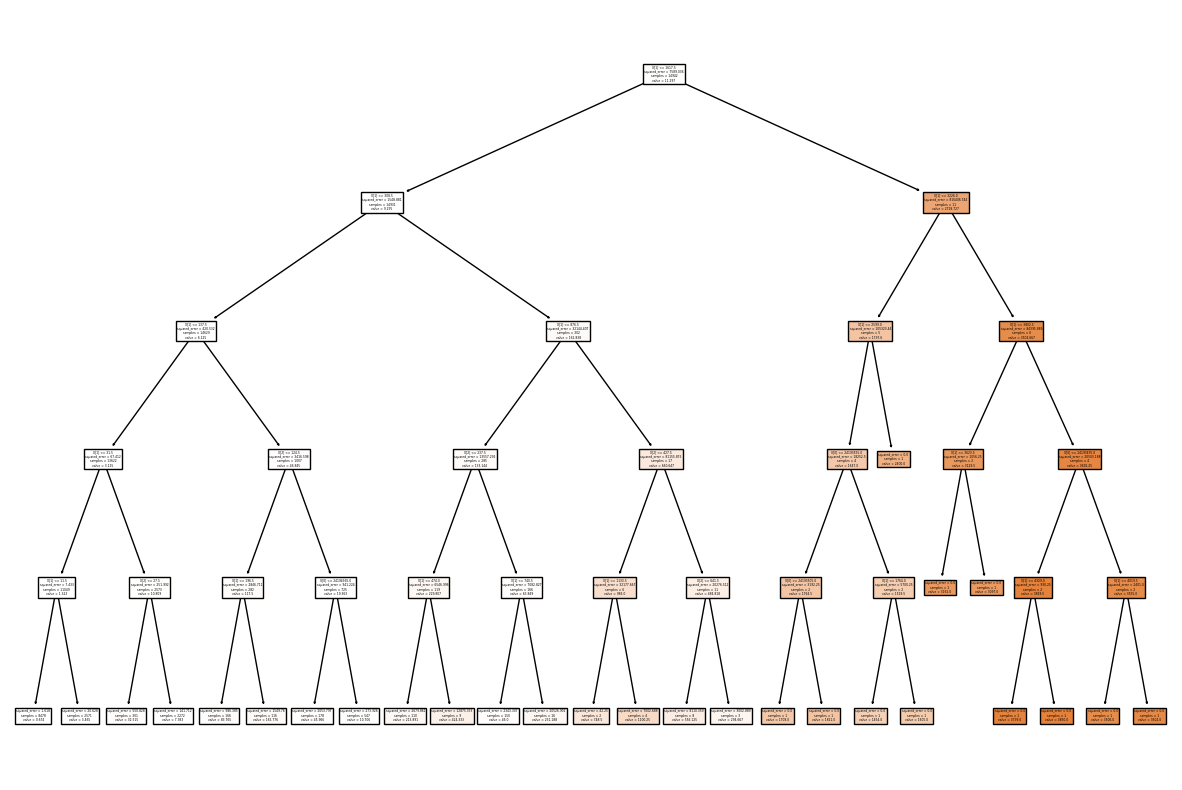

In [31]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))
plot_tree(reg_tree, filled=True, ax=ax)
plt.show()
